In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dill as pickle
import re

In [2]:
folder = Path("../data/raw")
csv_paths = sorted(folder.glob("*.csv"))
dfs = {p.stem: pd.read_csv(p,delimiter="\t") for p in csv_paths}

In [3]:
datasets = [k for k in dfs]
print(datasets)
for i in datasets[:5]:
    print(dfs[i].columns)
    print()

['FinanceBench-1_1_1', 'amg-1_1_x', 'hpcg-1_3_X', 'linux_kernel-1_14_X', 'miniFE-1_0_X', 'nqueens-1_2_X', 'numenta_nab-1_1_X', 'numpy-1_2_X', 'nwchem', 'openfoam-1_2_X', 'openradioss-1_2_X', 'pybench-1_1_X', 'specfem3d-1_1_X', 'stockfish-1_5_X', 'tensorflow-lite-1_1_X']
Index(['Component', 'Percentile Rank', '# Compatible Public Results',
       'ms (Average)'],
      dtype='object')

Index(['Component', 'Percentile Rank', '# Compatible Public Results',
       'Figure Of Merit (Average)'],
      dtype='object')

Index(['Component', 'Percentile Rank', '# Compatible Public Results',
       'GFLOP/s (Average)'],
      dtype='object')

Index(['Component', 'Percentile Rank', '# Compatible Public Results',
       'Seconds (Average)'],
      dtype='object')

Index(['Component', 'Percentile Rank', '# Compatible Public Results',
       'CG Mflops (Average)'],
      dtype='object')



We are going to make assumptions:
1. "Component" refers to the observed hardware model for all input data.
2. "Percentile Rank" is uninteresting and can be dropped.
3. "# Compatible Public Results" is present and can be renamed to "# Replicates"
4. The remaining column can be copied to "Score" as long as we create a Units column.
5. The +/- X refers to Standard Deviation, which should be moved to a separate column.
6. Clean up test names. Mostly for future aesthetics.

These assumptions will help us move the data to a long format.

Unfortunately, these assumptions specialize our pipeline to our dataset.

In [4]:
transformed = {}
for i in datasets:
    new = dfs[i].drop(columns=['Percentile Rank'])
    new = new.rename(columns={"# Compatible Public Results": "Samples"})
    
    cols = new.columns
    
    new["Test"] = i.split("-")[0]
    new["Units"] = cols[-1]
    new["Score"] = new[cols[-1]]
    new = new.drop(columns=[cols[-1]])
    
    vals = new["Score"].str.split(" ")
    val = [i[0] for i in list(vals)]
    sd = [i[-1] for i in list(vals)]

    new["Score"]=val
    new["SD"] = sd
    transformed[i]= new

In [5]:
long_df = pd.concat(transformed,ignore_index=True)
long_df

,Component,Samples,Test,Units,Score,SD
0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40
1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181
2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242
3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53
4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608
...,...,...,...,...,...,...
2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608
2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55
2147,Intel Core i7-7700,3.0,tensorflow,Microseconds (Average),55387,2995
2148,ARMv8 Cortex-A72 4-Core,5.0,tensorflow,Microseconds (Average),68651,3119


In [6]:
# Caught these by visual inspection. It's not the prettiest way to handle the analysis.
special_exclusions = ["Median","Mid-Tier","Low-Tier"]
print([i in (long_df["Component"].unique()) for i in special_exclusions])

long_df = long_df[~long_df["Component"].isin(special_exclusions)]
long_df

[True, True, True]


,Component,Samples,Test,Units,Score,SD
0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40
1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181
2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242
3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53
4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608
...,...,...,...,...,...,...
2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608
2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55
2147,Intel Core i7-7700,3.0,tensorflow,Microseconds (Average),55387,2995
2148,ARMv8 Cortex-A72 4-Core,5.0,tensorflow,Microseconds (Average),68651,3119


Now we are also going to drop the non Intel or AMD models. This is a limitation of our work.

We don't have a lot of non Intel/AMD options, and comparability is often poor without them due to them being historically dominant and only recently having alternatives (i.e. ARM desktop options).

In [7]:
subs = ["AMD", "Intel"]
pattern = "|".join(re.escape(s) for s in subs)
long_df = long_df[long_df["Component"].str.contains(pattern, case=False, na=False, regex=True)]
long_df.reset_index(inplace=True)
long_df

,index,Component,Samples,Test,Units,Score,SD
0,0,AMD Ryzen 9 9950X 16-Core,11.0,FinanceBench,ms (Average),25684,40
1,1,AMD RYZEN AI MAX+ 395,5.0,FinanceBench,ms (Average),28695,181
2,2,Intel Core i9-13900K,16.0,FinanceBench,ms (Average),30855,242
3,3,AMD Ryzen 7 7700X 8-Core,9.0,FinanceBench,ms (Average),31891,53
4,4,AMD Ryzen 9 7950X 16-Core,9.0,FinanceBench,ms (Average),31980,608
...,...,...,...,...,...,...,...
1959,2143,Intel Core i3-1005G1,4.0,tensorflow,Microseconds (Average),9975,7
1960,2144,2 x AMD EPYC 7773X 64-Core,8.0,tensorflow,Microseconds (Average),10045,535
1961,2145,AMD Ryzen 3 3200U,3.0,tensorflow,Microseconds (Average),23400,1608
1962,2146,Intel Core i3-3110M,3.0,tensorflow,Microseconds (Average),27422,55


In [8]:
long_df.to_csv("../data/intermediate/long_data.csv")

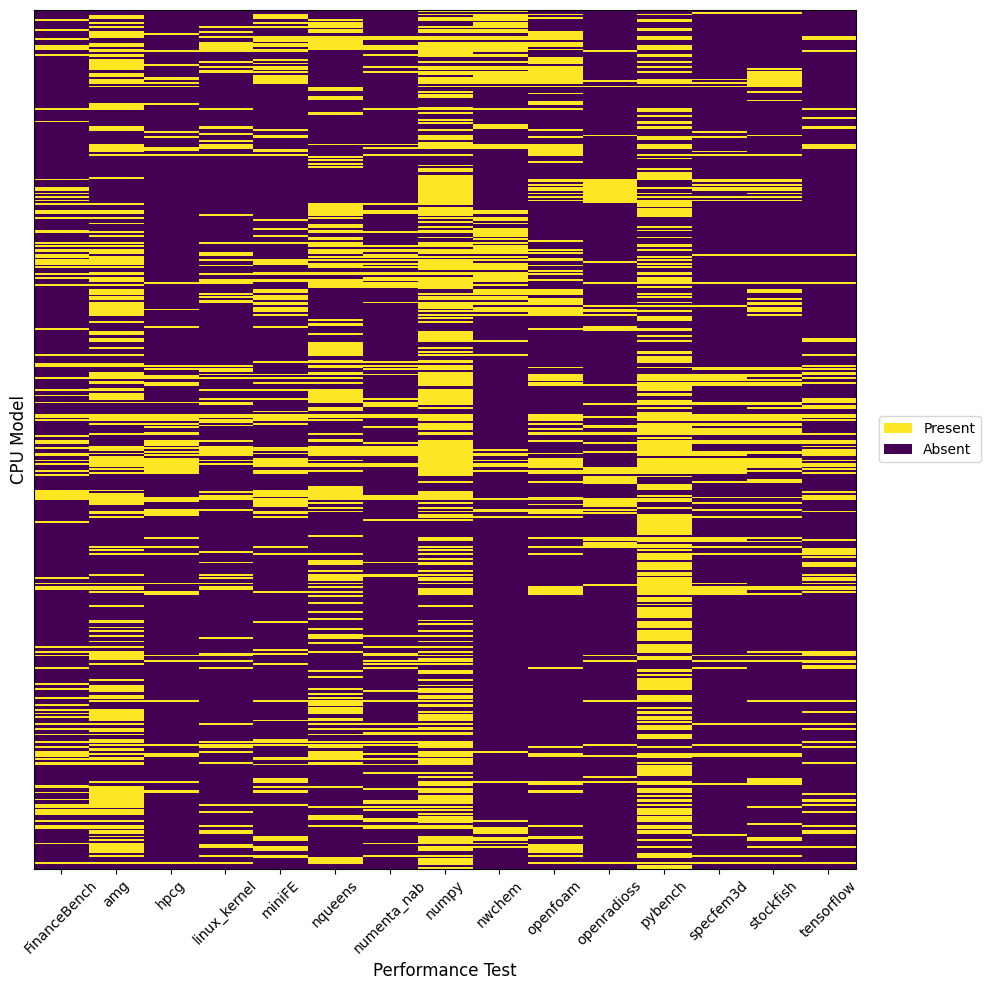

In [9]:
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

col_items  = "Component"   # rows
col_values = "Test"        # columns
tmp = long_df[[col_items, col_values]].dropna()

# Co-occurrence table (0/1)
M = pd.crosstab(tmp[col_items], tmp[col_values]).gt(0).astype(int)

cmap = mcolors.ListedColormap(["#440154", "#FDE725"])
norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(M.values, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)

handles = [Patch(facecolor=cmap(1), label="Present"),
           Patch(facecolor=cmap(0), label="Absent")]
ax.legend(handles=handles,
          loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=True)

ax.set_ylabel("CPU Model", fontsize=12)
ax.set_yticks([])
ax.set_xlabel("Performance Test", fontsize=12)
ax.set_xticks(range(len(M.columns))); ax.set_xticklabels(M.columns, rotation=45)

fig.tight_layout()
fig.savefig("../images/model-test-incidence.png", dpi=200, bbox_inches="tight")
plt.show()

We see that many models are missing across many tests.

In [10]:
num_models = len(long_df["Component"].unique())
print(num_models)

489


In [11]:
M = pd.crosstab(tmp[col_items], tmp[col_values]).gt(0).astype(int)
proportion_present = M.sum()/num_models
proportion_present

Test
FinanceBench    0.208589
amg             0.429448
hpcg            0.141104
linux_kernel    0.186094
miniFE          0.235174
nqueens         0.355828
numenta_nab     0.182004
numpy           0.574642
nwchem          0.210634
openfoam        0.263804
openradioss     0.134969
pybench         0.556237
specfem3d       0.161554
stockfish       0.198364
tensorflow      0.177914
dtype: float64

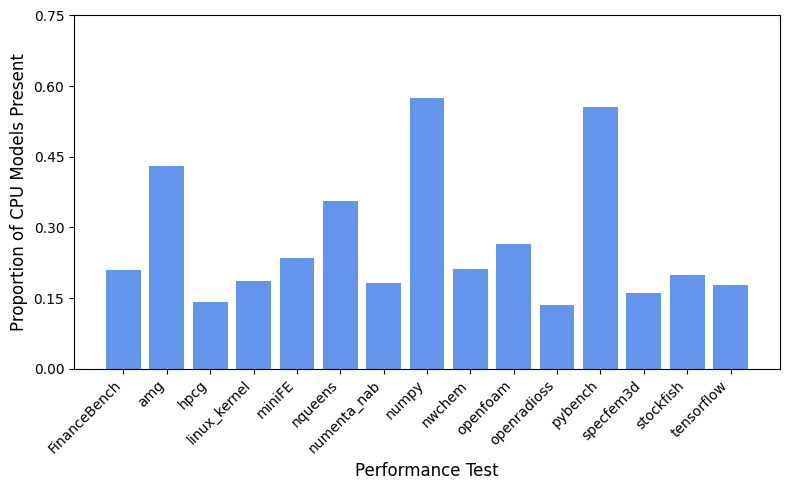

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))

x_labels = list(M.columns)
y_vals = pd.Series(proportion_present).reindex(x_labels).values
x = np.arange(len(x_labels))

ax.bar(x, y_vals, width=0.8,color="cornflowerblue")
ax.set_ylabel("Proportion of CPU Models Present", fontsize=12)
ax.set_yticks(np.linspace(0, 0.75, 6))
ax.set_xlabel("Performance Test", fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha="right")

fig.tight_layout()
fig.savefig("../images/proportion_present_across_tests.png", dpi=200, bbox_inches="tight")
plt.show()


We need to determine the approach we will take to handle missing data.

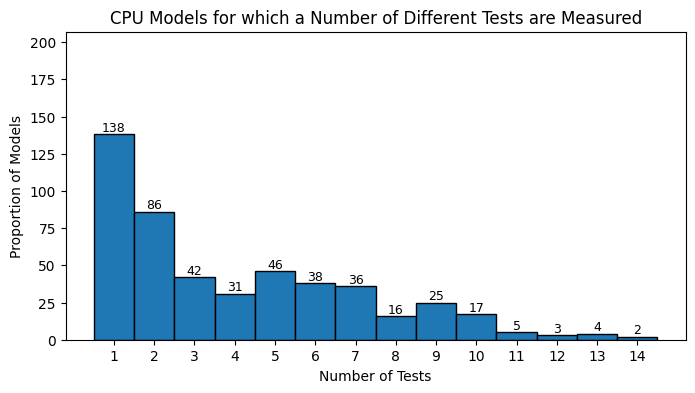

In [13]:
import numpy as np
import matplotlib.pyplot as plt

s = M.sum(axis=1).astype(int)
s = s[(s >= 1) & (s <= 14)]

bins = np.arange(0.5, 14.5 + 1, 1)

plt.figure(figsize=(8,4))
n, b, patches = plt.hist(s, bins=bins, edgecolor="black")  # proportions
plt.xticks(range(1, 15))
plt.ylim(0, 1.5*max(n))
plt.xlabel("Number of Tests")
plt.ylabel("Proportion of Models")
plt.title("CPU Models for which a Number of Different Tests are Measured")

# annotate each bar with its proportion
for height, patch in zip(n, patches):
    if height > 0:
        x = patch.get_x() + patch.get_width() / 2
        y = height
        plt.text(x, y, f"{int(height)}", ha="center", va="bottom", fontsize=9)

plt.savefig("../images/number_of_models_with_different_number_of_tests.png")
plt.show()

In [14]:
unique_models = long_df["Component"].unique()
with open("../data/intermediate/CPU_models.pkl", "wb") as f:
    pickle.dump(unique_models, f)

In [15]:
# Process model list
import re

_MULTIPLIER_RE = re.compile(r'^\s*(?P<multi>\d+)\s*(?:x|×)\s*', re.IGNORECASE)

_TRAILING_CORES_THREADS_RE = re.compile(
    r"""
    \s*                              
    (?:\(\s*)?                       
    (?:[/,]|and)?\s*                 
    \d+\s*-?\s*(?:core|cores|c)\b    
    (?:                              
        \s*(?:[/,]|and)\s*
        \d+\s*-?\s*(?:thread|threads|t)\b
    )?
    \s*(?:\)\s*)?                    
    \s*$                             
    """,
    re.IGNORECASE | re.VERBOSE,
)

def normalize_model_and_multiplier(raw: str) -> tuple[str, int]:
    """
    Returns (base_model, multiplier).
      - base_model has any leading "<n> x" stripped
        and any trailing "<n>-Core[/<m>-Thread]" stripped.
      - multiplier is the leading <n> (default 1).
    """
    s = raw.strip()

    multiplier = 1
    m = _MULTIPLIER_RE.match(s)
    if m:
        multiplier = int(m.group("multi"))
        s = s[m.end():]  # chop it off

    s = _TRAILING_CORES_THREADS_RE.sub("", s)

    s = " ".join(s.split())
    return s, multiplier

clean_models = []
multipliers = []
for model in unique_models:
    clean, mult = normalize_model_and_multiplier(model)
    clean_models.append(clean)
    multipliers.append(mult)

model_comparisons = pd.DataFrame({"Models":unique_models,"Cleaned":clean_models, "Multipliers":multipliers})
model_comparisons.to_csv("../data/intermediate/Models.csv")

In [16]:
model_comparisons

,Models,Cleaned,Multipliers
0,AMD Ryzen 9 9950X 16-Core,AMD Ryzen 9 9950X,1
1,AMD RYZEN AI MAX+ 395,AMD RYZEN AI MAX+ 395,1
2,Intel Core i9-13900K,Intel Core i9-13900K,1
3,AMD Ryzen 7 7700X 8-Core,AMD Ryzen 7 7700X,1
4,AMD Ryzen 9 7950X 16-Core,AMD Ryzen 9 7950X,1
...,...,...,...
484,2 x Intel Xeon E5-2687W 0,Intel Xeon E5-2687W 0,2
485,Intel Core i7-12700KF,Intel Core i7-12700KF,1
486,2 x Intel Xeon Gold 6144,Intel Xeon Gold 6144,2
487,Intel Core i7-1185G7E,Intel Core i7-1185G7E,1
